**1. Datasets & Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import seaborn as sns
from string import punctuation

from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer

import os
import zipfile
import warnings
import subprocess

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

# Function to download and unzip wordnet data
def download_and_unzip_wordnet():
    nltk.download('wordnet', download_dir='/kaggle/working/')
    zip_path = '/kaggle/working/corpora/wordnet.zip'
    extract_path = '/kaggle/working/corpora/'
    
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    nltk.data.path.append('/kaggle/working/')

# Check if wordnet is available
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    download_and_unzip_wordnet()

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


**2. Import Data**

In [2]:
true_df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv")
fake_df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv")

In [3]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [4]:
true_df.shape

(21417, 4)

In [5]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


<Axes: >

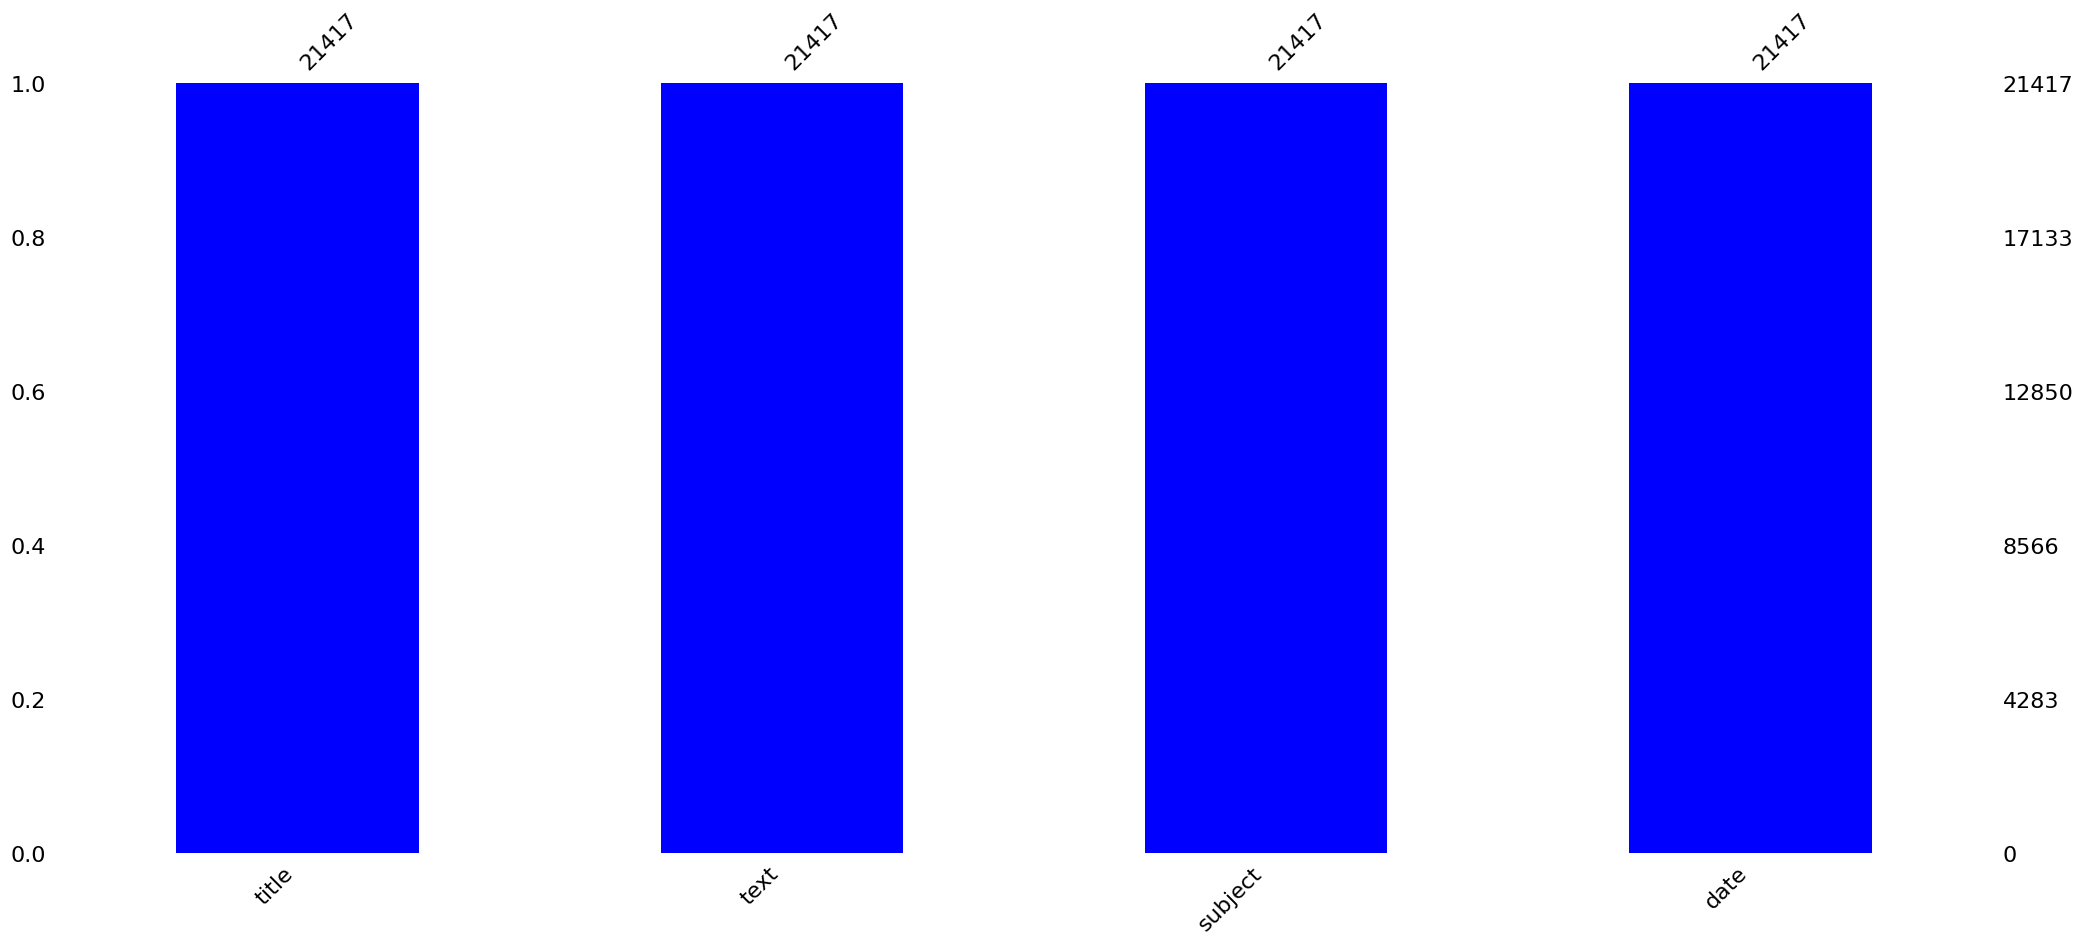

In [6]:
import missingno as msno
msno.bar(true_df, color = 'b')

In [7]:
true_df.duplicated().sum()

206

In [8]:
true_df.drop_duplicates(inplace=True)

In [9]:
fake_df.shape

(23481, 4)

In [10]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


<Axes: >

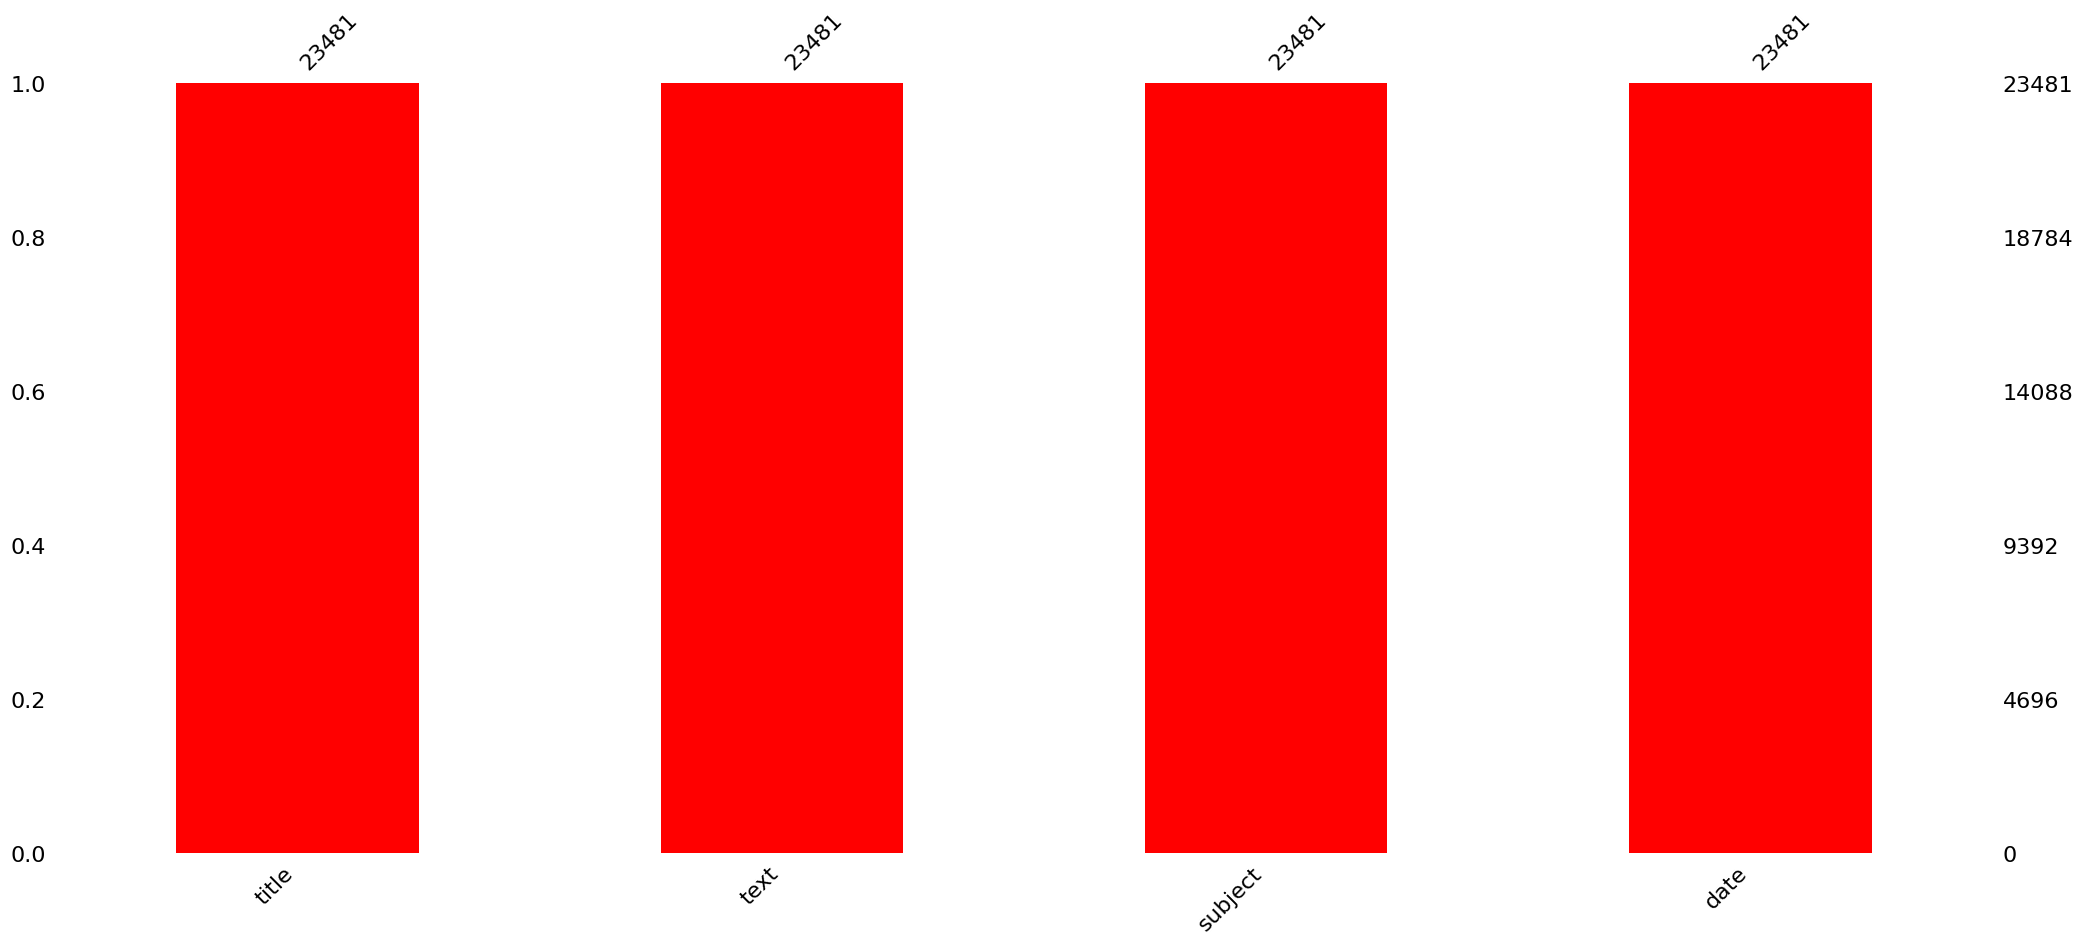

In [12]:
msno.bar(fake_df, color = 'r')

In [13]:
fake_df.duplicated().sum()

3

In [14]:
fake_df.drop_duplicates(inplace=True)

**3. Feature Engineering**

In [15]:
true_df['label'] = 1
fake_df['label'] = 0

In [16]:
news_df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [17]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [18]:
news_df['date'] = pd.to_datetime(news_df['date'],format='mixed', dayfirst=True,errors='coerce')

news_df['Year'] = news_df['date'].dt.year
news_df['Month'] = news_df['date'].dt.month_name()

In [19]:
news_df.columns = news_df.columns.str.replace('_', ' ').str.title()

In [20]:
from nltk.stem import PorterStemmer
#Clean text
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

news_df['Text'] = news_df['Text'].apply(lambda x: clean(x))
news_df['Title'] = news_df['Title'].apply(lambda x: clean(x))

**4.Exploratory Data Analysis**

**Univariate Analysis**

Label
0    23478
1    21211
Name: count, dtype: int64

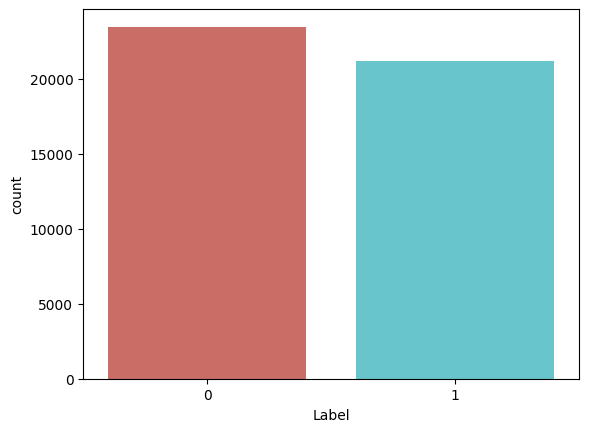

In [21]:
def create_distribution(dataFile):
    return sns.countplot(x='Label', data=dataFile, palette='hls')

create_distribution(news_df)

news_df['Label'].value_counts()

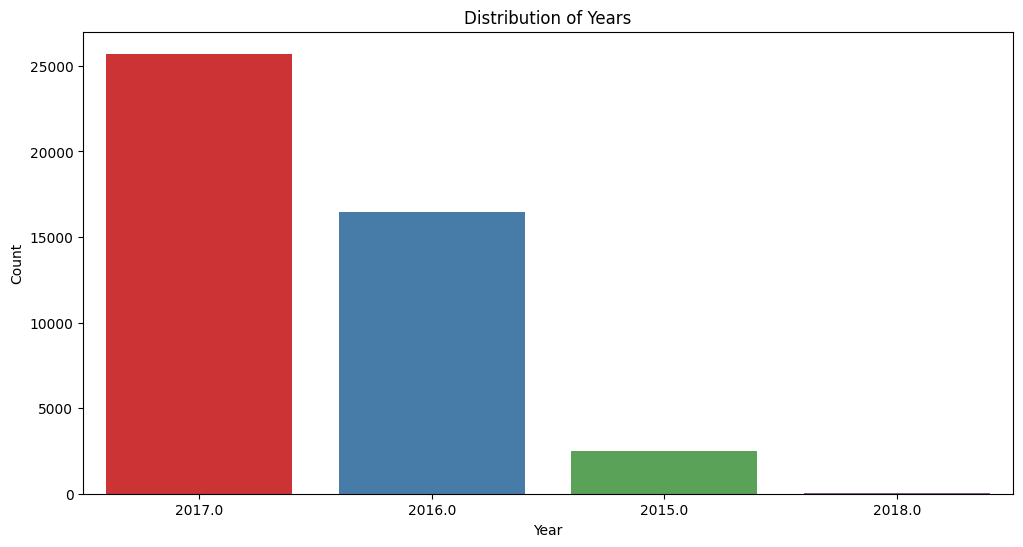

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=news_df, order=news_df['Year'].value_counts().index, palette='Set1')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

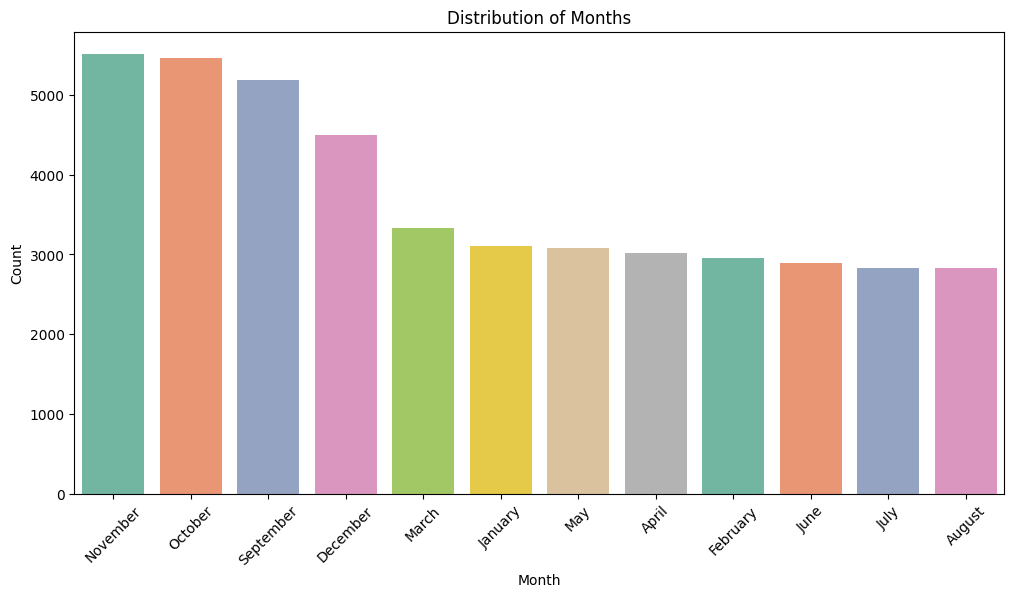

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=news_df, order=news_df['Month'].value_counts().index, palette='Set2')
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

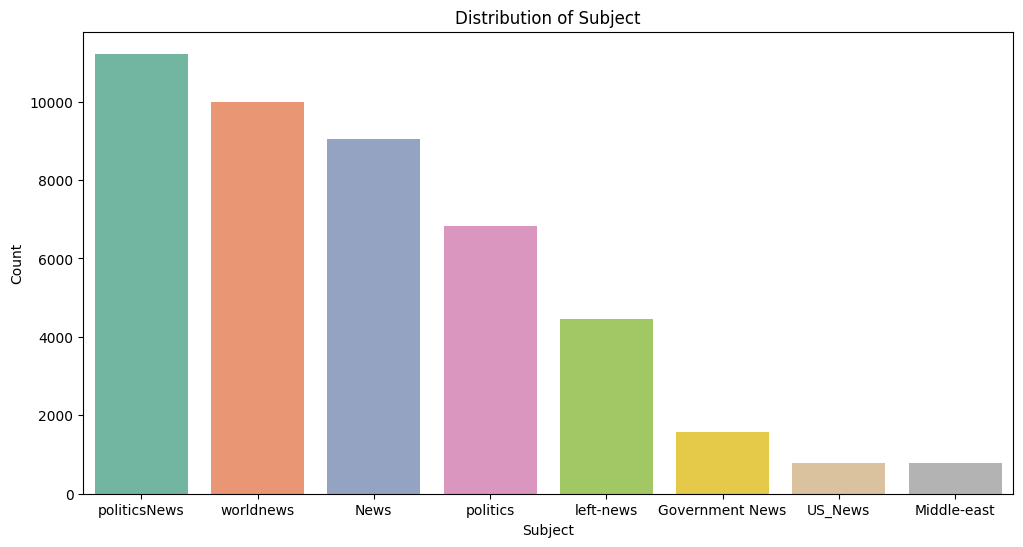

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Subject', data=news_df, order=news_df['Subject'].value_counts().index, palette='Set2')
plt.title('Distribution of Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Bivariate Analysis**

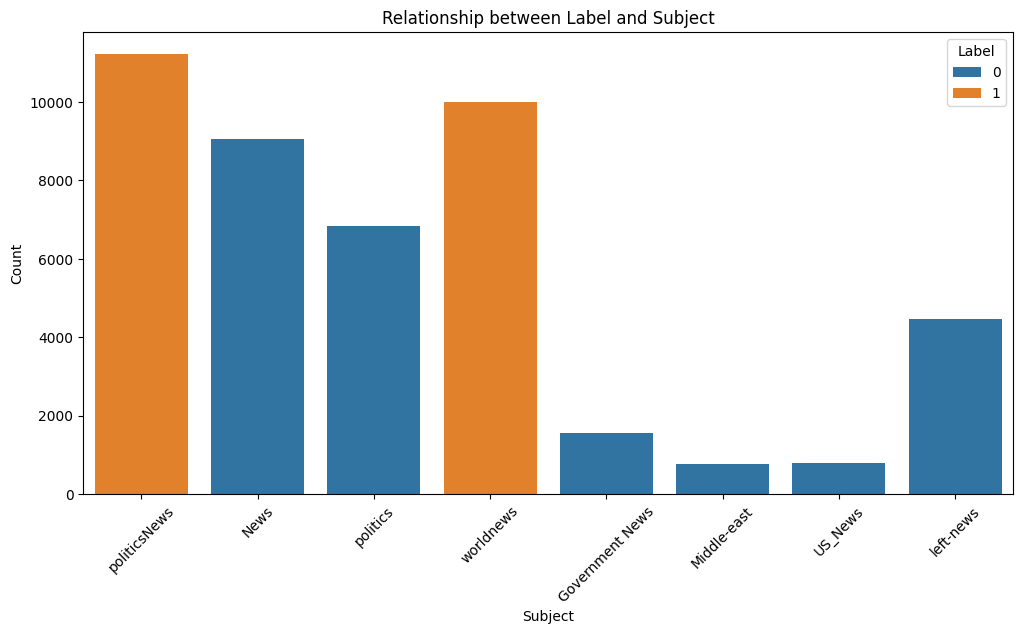

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Subject', hue='Label', data=news_df)
plt.title('Relationship between Label and Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

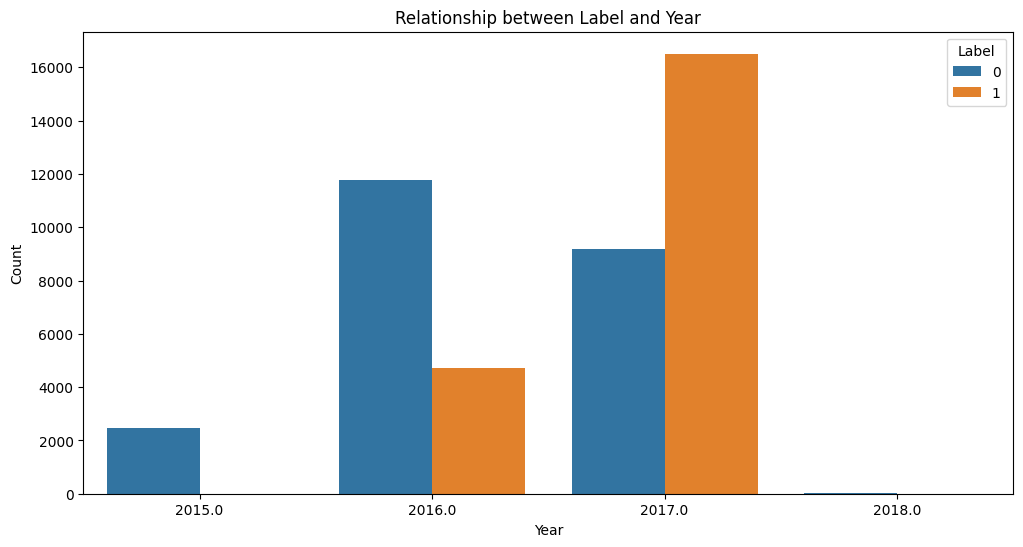

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Label', data=news_df)
plt.title('Relationship between Label and Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

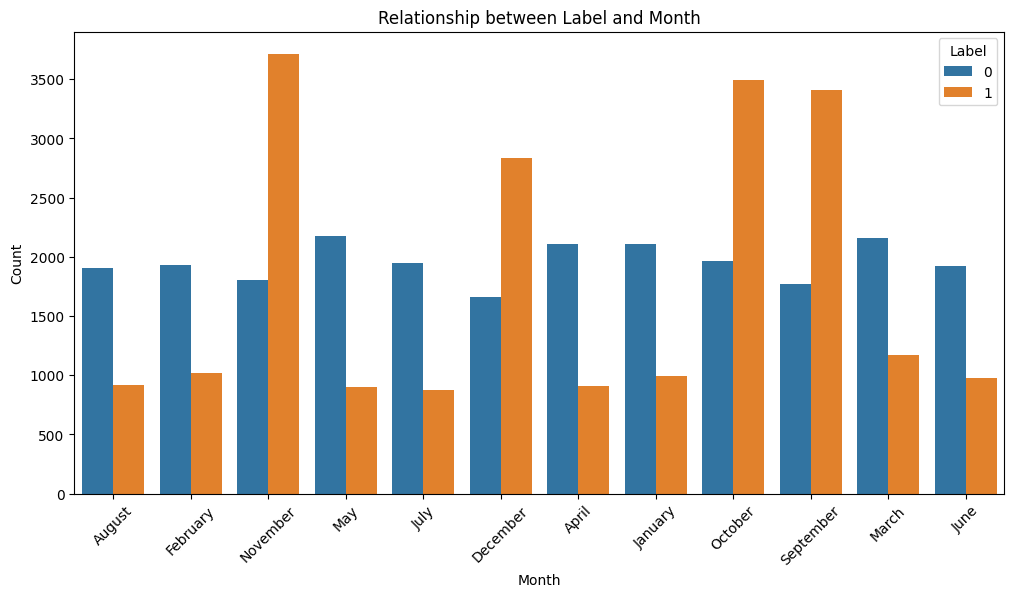

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Label', data=news_df)
plt.title('Relationship between Label and Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Bigrams Text**

In [28]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

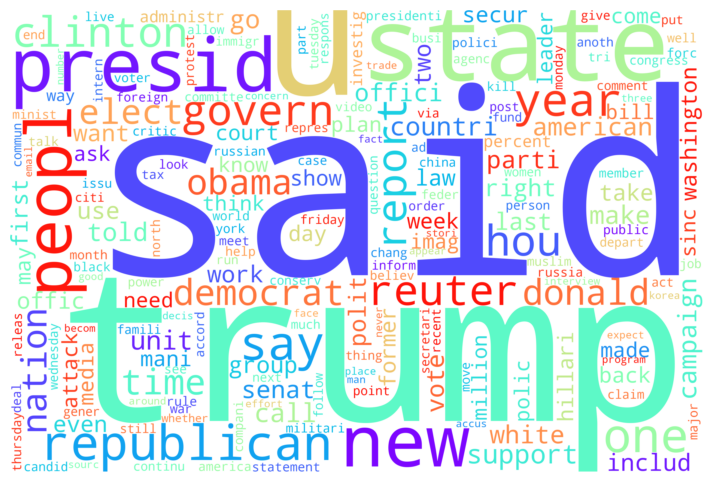

In [29]:
text = " ".join(news_df['Text'].astype(str))


wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='rainbow', collocations=False, stopwords=STOPWORDS).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

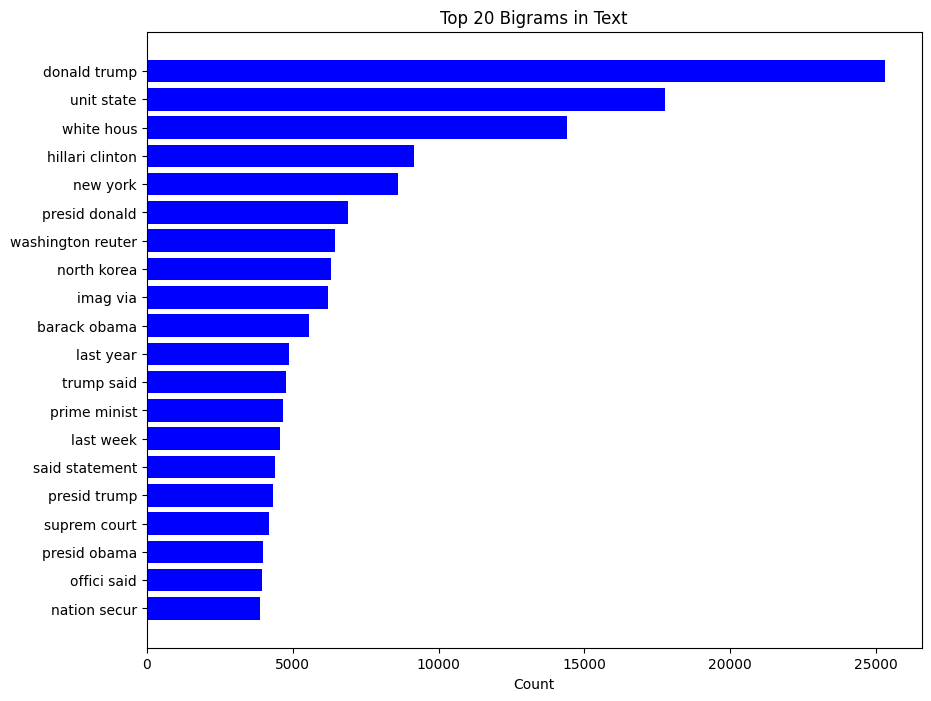

In [30]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigram(news_df['Text'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis()
plt.show()

**Bigrams Title**

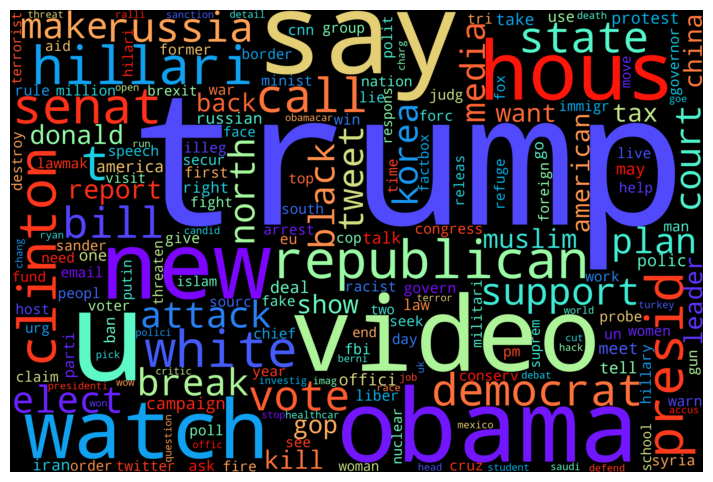

In [31]:
text = " ".join(news_df['Title'].astype(str))


wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords=STOPWORDS).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

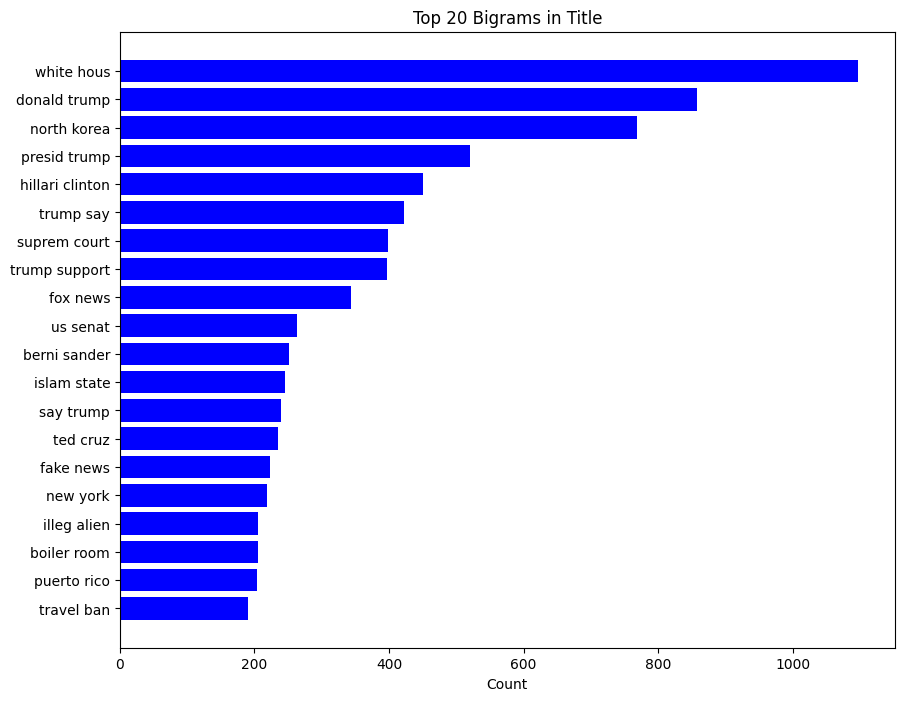

In [32]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigram(news_df['Title'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Title')
plt.gca().invert_yaxis()
plt.show()

**5.Sentiment Analysis**

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 

In [34]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis with progress bar
res = {}
for i, row in tqdm(news_df.iterrows(), total=len(news_df), desc="Sentiment Analysis"):
    text = row['Text']
    my_id = row['Title']
    score = sia.polarity_scores(text)
    res[my_id] = score

Sentiment Analysis:   0%|          | 0/44689 [00:00<?, ?it/s]

In [35]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Title'})
vaders = vaders.merge(news_df, how='left')

In [36]:
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.5:
        return "negative"
    else:
        return "neutral"

vaders['sentiment'] = vaders['compound'].apply(lambda val: polarity_score(val))

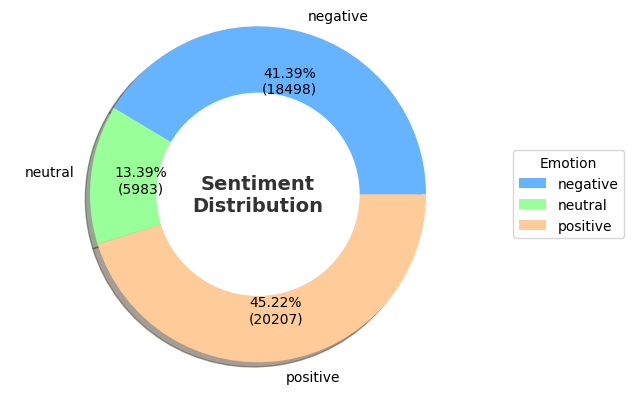

In [37]:
unique_emotion = vaders['sentiment'].unique()

explode = [0] * len(unique_emotion)

emotion_counts = vaders.groupby("sentiment").size()

colors = ['#66b3ff', '#99ff99', '#ffcc99']  

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=emotion_counts, 
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

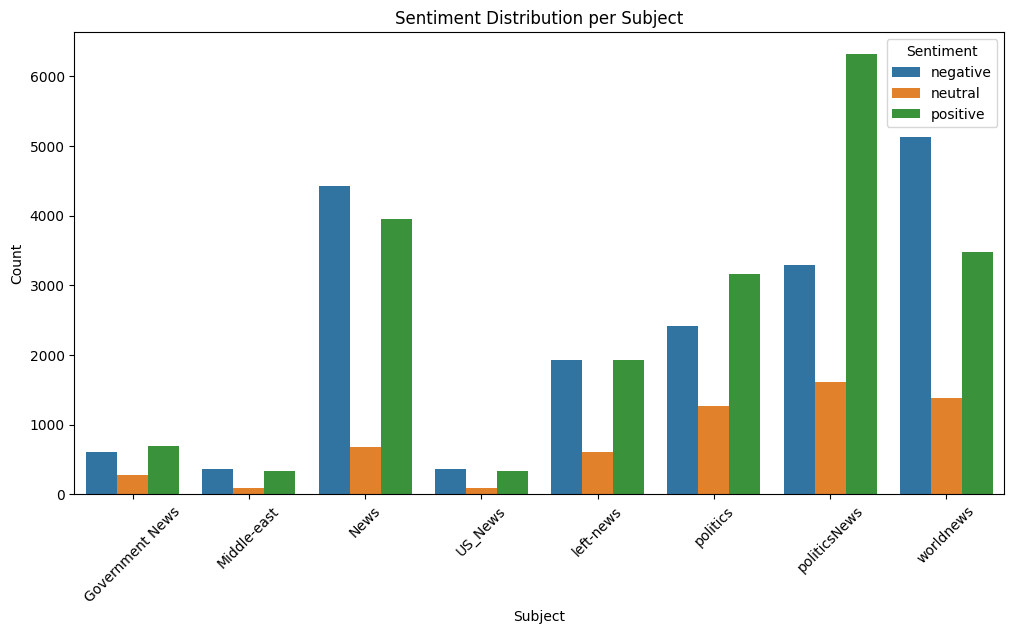

In [38]:
sentiment_counts = vaders.groupby(['Subject', 'sentiment'])['sentiment'].count().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='count', hue='sentiment', data=sentiment_counts)

plt.title('Sentiment Distribution per Subject')
plt.xlabel('Subject')
plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.xticks(rotation=45)

plt.show()

**3. Data Preprocessing**

1. lowercase conversion
2. removing stop words
3. removing punctuations
4. Lemmatizing
5. removing tags
6. removing special characters

In [39]:
from imblearn.over_sampling import RandomOverSampler
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [40]:
df = vaders.copy()

In [41]:
df['content'] = df['Title'] + ' ' + df['Text']

In [42]:
X = df['content']
y = df['Label']

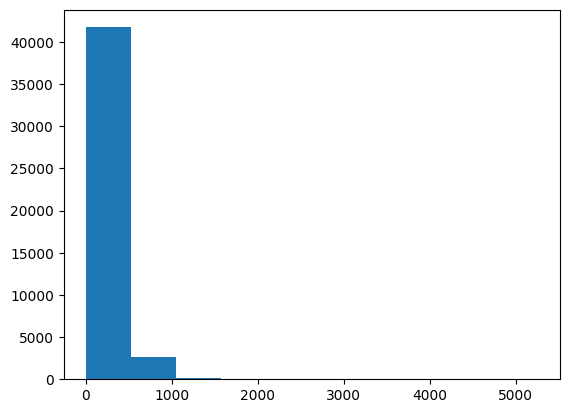

In [43]:
text_lengths = X.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

**Data Scaling**

In [44]:
#Scaling "Label"
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df['content'].values.reshape(-1, 1), df['Label'])
X_res = X_res.flatten()


In [45]:
tokenizer = Tokenizer(num_words=50000, oov_token='OOV')
tokenizer.fit_on_texts(X_res)
sequences = tokenizer.texts_to_sequences(X_res)
padded = pad_sequences(sequences, maxlen=1000)

**Split Data**

In [46]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(padded, y_res, test_size=0.2, random_state=42)

# Split training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [47]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(Label
 1    15047
 0    15004
 Name: count, dtype: int64,
 Label
 0    3758
 1    3755
 Name: count, dtype: int64,
 Label
 0    4716
 1    4676
 Name: count, dtype: int64)

**LOGISTIC REGRESSION**

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [49]:
# Split data into features and labels
X = df[['Title', 'Text']]
y = df['Label']

# Combine 'title' and 'text' columns for vectorization
X['combined'] = X['Title'] + ' ' + X['Text']


In [50]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Split the temporary set into validation and testing sets (50% val, 50% test, which is 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [51]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and testing data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

In [52]:
# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(random_state=42)

# Fit the model on the training data
log_reg.fit(X_train_vectorized, y_train)

LogisticRegression(random_state=42)

In [53]:
# Predict on the validation data
y_val_preds = log_reg.predict(X_val_vectorized)

In [54]:
# Evaluate the model on the validation data
val_accuracy = accuracy_score(y_val, y_val_preds)*100
val_precision = precision_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed
val_f1 = f1_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed

print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Validation Precision: {val_precision:.2f}%')
print(f'Validation F1 Score: {val_f1:.2f}%')

Validation Accuracy: 99.02%
Validation Precision: 98.69%
Validation F1 Score: 98.97%


In [55]:
# Predict on the test data
y_test_preds = log_reg.predict(X_test_vectorized)

In [56]:
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_preds)*100
test_precision = precision_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed
test_f1 = f1_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Precision: {test_precision:.2f}%')
print(f'Test F1 Score: {test_f1:.2f}%')

Test Accuracy: 98.81%
Test Precision: 98.35%
Test F1 Score: 98.75%


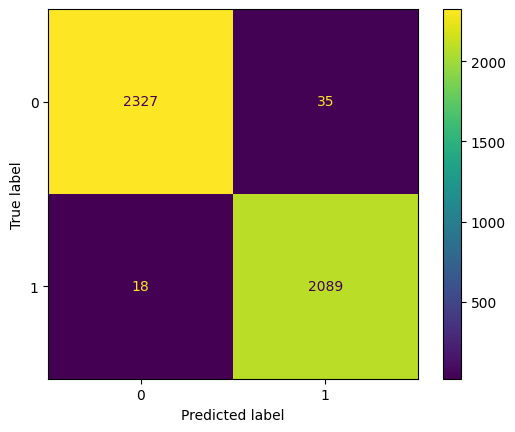

In [57]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

**RANDOM FOREST**

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [59]:
# Split data into features and labels
X = df[['Title', 'Text']]
y = df['Label']


In [60]:
# Combine 'title' and 'text' columns for vectorization
X['combined'] = X['Title'] + ' ' + X['Text']

In [61]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Split the temporary set into validation and testing sets (50% val, 50% test, which is 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [62]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and testing data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

In [63]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)

In [64]:
# Fit the model on the training data
rf.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

In [65]:
# Predict on the validation data
y_val_preds = rf.predict(X_val_vectorized)

In [66]:
# Evaluate the model on the validation data
val_accuracy = accuracy_score(y_val, y_val_preds)
val_precision = precision_score(y_val, y_val_preds, average='binary')  # Adjust for multiclass if needed
val_f1 = f1_score(y_val, y_val_preds, average='binary')  # Adjust for multiclass if needed


In [67]:
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation F1 Score: {val_f1:.2f}')

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation F1 Score: 0.99


In [68]:
# Predict on the test data
y_test_preds = rf.predict(X_test_vectorized)

In [69]:
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_preds)*100
test_precision = precision_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed
test_f1 = f1_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed

In [70]:
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Precision: {test_precision:.2f}%')
print(f'Test F1 Score: {test_f1:.2f}&')

Test Accuracy: 99.24%
Test Precision: 99.19%
Test F1 Score: 99.19&


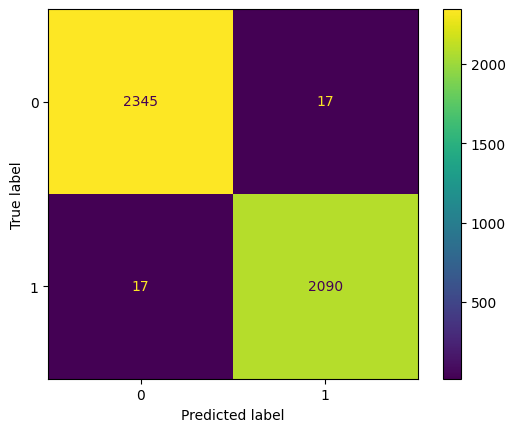

In [71]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

**DECISION TREE**

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into features and labels
X = df[['Title', 'Text']]
y = df['Label']

# Combine 'title' and 'text' columns for vectorization
X['combined'] = X['Title'] + ' ' + X['Text']

In [74]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Split the temporary set into validation and testing sets (50% val, 50% test, which is 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [75]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and testing data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)


In [76]:
# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)


# Fit the model on the training data
decision_tree.fit(X_train_vectorized, y_train)

DecisionTreeClassifier(random_state=42)

In [77]:
# Predict on the validation data
y_val_preds = decision_tree.predict(X_val_vectorized)


In [78]:

# Evaluate the model on the validation data
val_accuracy = accuracy_score(y_val, y_val_preds)*100
val_precision = precision_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed
val_f1 = f1_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed

print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Validation Precision: {val_precision:.2f}%')
print(f'Validation F1 Score: {val_f1:.2f}%')

Validation Accuracy: 99.62%
Validation Precision: 99.67%
Validation F1 Score: 99.60%


In [79]:
# Predict on the test data
y_test_preds = decision_tree.predict(X_test_vectorized)

In [80]:
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_preds)*100
test_precision = precision_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed
test_f1 = f1_score(y_test, y_test_preds, average='binary') *100 # Adjust for multiclass if needed

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Precision: {test_precision:.2f}%')
print(f'Test F1 Score: {test_f1:.2f}%')

Test Accuracy: 99.64%
Test Precision: 99.67%
Test F1 Score: 99.62%


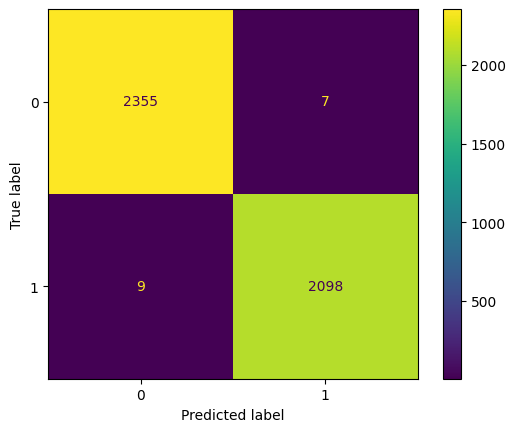

In [81]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

**Support Vector Machine (SVM)**

In [82]:
from sklearn.svm import SVC

In [83]:
# Split data into features and labels
X = df[['Title', 'Text']]
y = df['Label']

In [84]:
# Combine 'title' and 'text' columns for vectorization
X['combined'] = X['Title'] + ' ' + X['Text']

In [85]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X['combined'], y, test_size=0.2, random_state=42)

# Split the temporary set into validation and testing sets (50% val, 50% test, which is 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [86]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and testing data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

In [87]:
# Initialize the SVM classifier
svm = SVC(kernel='linear')  # You can choose other kernels like 'rbf', 'poly', etc.

In [88]:
# Fit the model on the training data
svm.fit(X_train_vectorized, y_train)


SVC(kernel='linear')

In [89]:
# Predict on the validation data
y_val_preds = svm.predict(X_val_vectorized)


In [90]:
# Evaluate the model on the validation data
val_accuracy = accuracy_score(y_val, y_val_preds)*100
val_precision = precision_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed
val_f1 = f1_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed

In [91]:
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Validation Precision: {val_precision:.2f}%')
print(f'Validation F1 Score: {val_f1:.2f}&')

Validation Accuracy: 99.53%
Validation Precision: 99.25%
Validation F1 Score: 99.51&


In [92]:
# Predict on the test data
y_test_preds = svm.predict(X_test_vectorized)

In [93]:
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_preds)*100
test_precision = precision_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed
test_f1 = f1_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed

In [94]:
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Precision: {test_precision:.2f}%')
print(f'Test F1 Score: {test_f1:.2f}%')

Test Accuracy: 99.37%
Test Precision: 99.01%
Test F1 Score: 99.34%


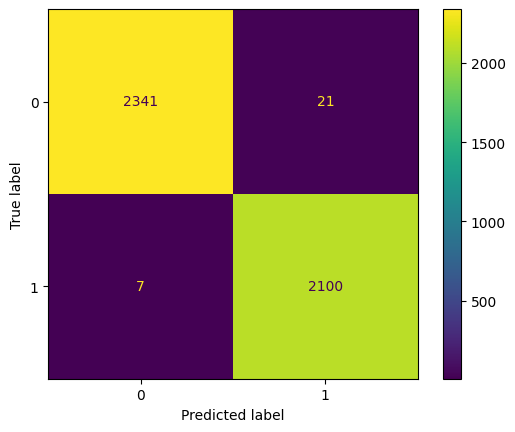

In [95]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

**k-Nearest Neighbors (KNN)**

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [97]:
df_X = df[['Title', 'Text']]
df_y = df['Label']

In [98]:
# Combine 'title' and 'text' columns for vectorization
df_X['combined'] = df_X['Title'] + ' ' + df_X['Text']

In [99]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(df_X['combined'], df_y, test_size=0.2, random_state=42)

# Split the temporary set into validation and testing sets (50% val, 50% test, which is 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [100]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and testing data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)


In [101]:
# Initialize the KNN classifier with k neighbors
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

In [102]:
# Fit the model on the training data
knn.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=3)

In [103]:
# Predict on the validation data
y_val_preds = knn.predict(X_val_vectorized)

In [104]:
# Evaluate the model on the validation data
val_accuracy = accuracy_score(y_val, y_val_preds)*100
val_precision = precision_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed
val_f1 = f1_score(y_val, y_val_preds, average='binary')*100  # Adjust for multiclass if needed


In [105]:
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Validation Precision: {val_precision:.2f}%')
print(f'Validation F1 Score: {val_f1:.2f}%')

Validation Accuracy: 80.38%
Validation Precision: 80.11%
Validation F1 Score: 79.17%


In [106]:
# Predict on the test data
y_test_preds = knn.predict(X_test_vectorized)

In [107]:
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_preds)*100
test_precision = precision_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed
test_f1 = f1_score(y_test, y_test_preds, average='binary')*100  # Adjust for multiclass if needed

In [108]:
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Precision: {test_precision:.2f}%')
print(f'Test F1 Score: {test_f1:.2f}%')

Test Accuracy: 80.51%
Test Precision: 79.86%
Test F1 Score: 79.15%


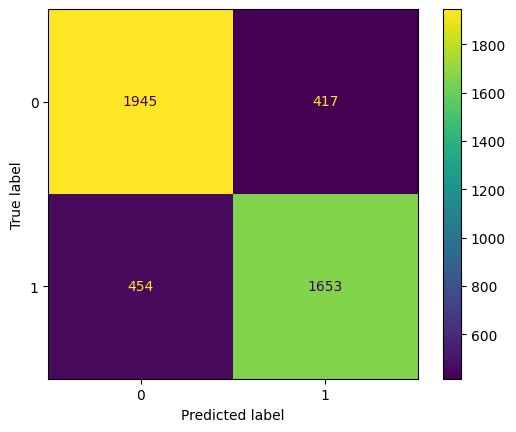

In [109]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

**Naive Bayes with TF-IDF**

In [110]:
# Create the pipeline 
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', MultinomialNB())])


In [111]:
# Fit the pipeline  
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [112]:
# Predict on the test set
preds = pipe.predict(X_test)

In [113]:
# Print classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2362
           1       0.94      0.93      0.94      2107

    accuracy                           0.94      4469
   macro avg       0.94      0.94      0.94      4469
weighted avg       0.94      0.94      0.94      4469



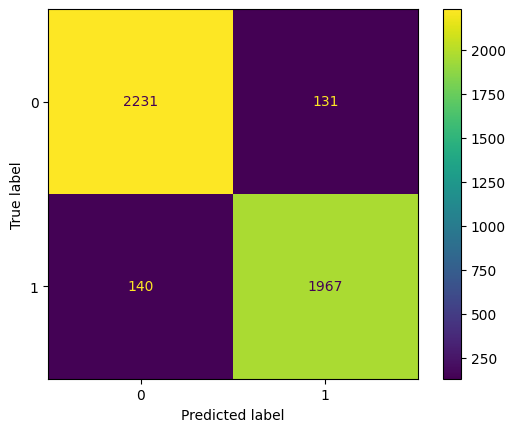

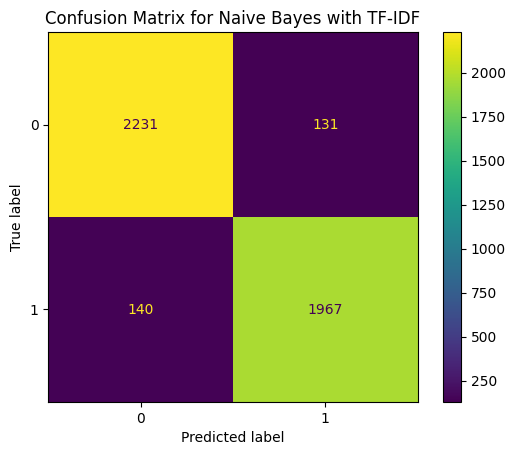

In [114]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
disp.plot()

# Show the plot
plt.title("Confusion Matrix for Naive Bayes with TF-IDF")
plt.show()


In [115]:
# Accuracy Score on train dataset
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
print('Accuracy Score on train dataset:', accuracy_train)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, preds)
print('Accuracy Score on test dataset:', accuracy_test)

Accuracy Score on train dataset: 0.9529803362143716
Accuracy Score on test dataset: 0.9393600358021928


In [116]:
# Precision on test dataset
precision_test = precision_score(y_test, preds, average='binary')*100  # Adjust for multiclass if needed
print("Precision on test dataset:{:2f}%".format(precision_test))

# F1 Score on test dataset
f1_test = f1_score(y_test, preds, average='binary')*100  # Adjust for multiclass if needed
print("F1 Score on test dataset:{:2f}%".format(f1_test))

Precision on test dataset:93.755958%
F1 Score on test dataset:93.555291%


**Naive Bayes with TF-IDF and Bi-Grams**

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the pipeline with TF-IDF vectorization and Naive Bayes classifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # TF-IDF with Bi-Grams
    ('clf', MultinomialNB())  # Naive Bayes classifier
])

In [118]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [119]:
# Predict on the test set
preds = pipe.predict(X_test)

In [120]:
# Print classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2362
           1       0.96      0.96      0.96      2107

    accuracy                           0.96      4469
   macro avg       0.96      0.96      0.96      4469
weighted avg       0.96      0.96      0.96      4469



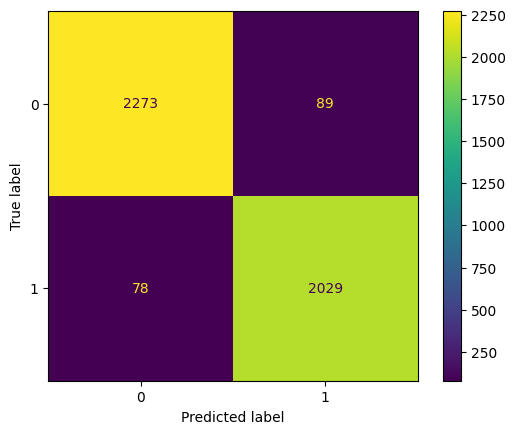

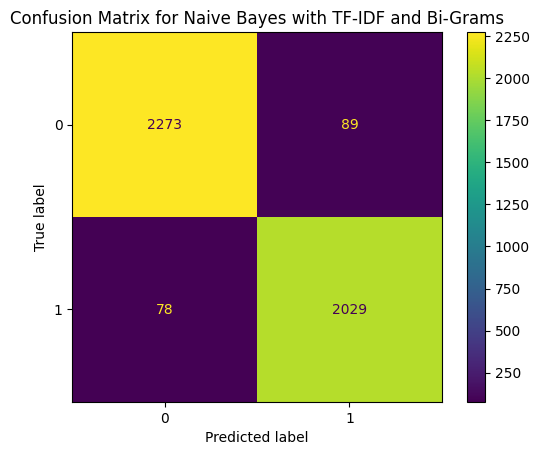

In [121]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
disp.plot()

# Show the plot
plt.title("Confusion Matrix for Naive Bayes with TF-IDF and Bi-Grams")
plt.show()

In [122]:
# Accuracy Score on train dataset
accuracy_train = accuracy_score(y_train, pipe.predict(X_train))
print('Accuracy Score on train dataset:', accuracy_train)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, preds)*100
print("Accuracy Score on test dataset:{:2f}%".format(accuracy_test))

Accuracy Score on train dataset: 0.9798607031971134
Accuracy Score on test dataset:96.263146%


In [123]:
# Precision on test dataset
precision_test = precision_score(y_test, preds, average='binary')*100  # Adjust for multiclass if needed
print("Precision on test dataset:{:2f}%".format(precision_test))

# F1 Score on test dataset
f1_test = f1_score(y_test, preds, average='binary')*100  # Adjust for multiclass if needed
print("F1 Score on test dataset:{:2f}%".format(f1_test))

Precision on test dataset:95.797923%
F1 Score on test dataset:96.047337%
